In [1]:
import os, sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import numpy as np
import torch
import torch.nn as nn 
import torchvision
import gc
import random
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Subset, DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, Lambda
from tqdm import tqdm_notebook as tqdm

from src import distributions
from src.unet import CondUNetV2, UNet
from src.mnistm_utils import MNISTM
from src.plotters import plot_images
from src.fid_score import calculate_frechet_distance
from src.guided_samplers import Sampler, SubsetGuidedDataset, get_indicies_subset
from src.tools import fig2data, fig2img, freeze, unfreeze, get_stats, compute_transport_accuracy, get_generated_stats_extended

## Plot Utils

In [2]:
class PairedPlotSampler(Sampler):
    def __init__(self, loader, subsetsize = 8, weight=None, device='cuda'):
        super(PairedPlotSampler, self).__init__(device)
        self.loader = loader
        self.subsetsize = subsetsize
        if weight is None:
            weight = [1/self.loader.num_classes for _ in range(self.loader.num_classes)]
        self.weight = weight
        
    def sample(self):
        classes = np.array(list(range(0,10)))
        batch_X = []
        batch_Y = []
        with torch.no_grad():
            for class_ in classes: 
                X, Y = self.loader.get(class_, self.subsetsize)
                batch_X.append(X.clone().to(self.device).float())
                batch_Y.append(Y.clone().to(self.device).float())
        return torch.stack(batch_X).to(self.device), torch.stack(batch_Y).to(self.device)

In [9]:
def plot_transport_results(X, Y, T_paths, DATASET, NC=1, ZD=128, Z_STD=1.0, m_data=None, s_data=None, X_sampler=None, labeled_X_sampler=None, classifier=None, metrics=False):
    FID = []
    accuracies = []
    fig, axes = plt.subplots(len(T_paths)+2, 10, figsize=(9, 3.5), dpi=150)
    axes[0, 0].set_ylabel('$x \sim \mathbb{P}_n$', fontsize=18)
    axes[1, 0].set_ylabel('$y \sim \mathbb{Q}_n$', fontsize=18)
    images = [X, Y]
    labels = ['$\mathcal{F}_{G, no \hspace{0.5} z }$ \n (ours)', '$\mathcal{F}_{G}$ \n (ours)']
    for it, (name, T_path) in enumerate(T_paths):
        
        if 'Weak' in name:
            ZD=128
            T = CondUNetV2(NC, NC, ZD, base_factor=48).cuda()
            T.load_state_dict(torch.load(T_path))
        else:
            T = UNet(NC, NC, base_factor=48).cuda()
            T.load_state_dict(torch.load(T_path))
        freeze(T)
        if 'Weak' in name:
            ZD=128
            with torch.no_grad():
                Z = torch.randn(10, 1, ZD, 1, 1, device='cuda') *Z_STD
                XZ = (X, Z.flatten(start_dim=0, end_dim=1))
                T_X = T(*XZ)
                images.append(T_X)
            axes[it+2, 0].set_ylabel("{}".format(labels[it]), fontsize=20)
        else:
            ZD=None
            with torch.no_grad():
                T_X = T(X)
                images.append(T_X)
            axes[it+2, 0].set_ylabel("{}".format(labels[it]), fontsize=20)
        
        if metrics:
            print('Method:', name)
            accuracy = compute_transport_accuracy(T, labeled_X_sampler, classifier, ZD = ZD, Z_STD = Z_STD, name = name)
            m, s = get_generated_stats_extended(T, X_sampler, size=10000, inception=False, batch_size=100, verbose=False, ZD = ZD, Z_STD = Z_STD, name = name)
            FD_T = calculate_frechet_distance(m, s, m_data, s_data)
            print('FID: ', FD_T)
            FID.append(FD_T)
            accuracies.append(accuracy)
            
    x_titles = [0,1,2,3,4,5,6,7,8,9]
    for i, title in enumerate(x_titles):
        axes[0,i].set_title(r'${}$'.format(title), fontsize=20)
    imgs = torch.cat(images).to('cpu').permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imgs[i], cmap='Greys')
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
    
    fig.tight_layout(pad=0.001)
    plt.show()
    return FID, accuracies, fig

## Init Parameters

In [4]:
SEED = 2022
IMG_SIZE = 32
BATCH_SIZE = 64
ZD = 128
Z_STD = 1.
DATASET = 'fmnist2mnist'
DATASET_PATH = '../datasets/'
save_path = '../results/'
models_path =[['Energy',f'../saved_models/{DATASET}/T_30000_no_z.pt'],
              ['Weak Energy',f'../saved_models/{DATASET}/T_30000.pt']]

source_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7 ,8, 9])
new_labels_source = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
target_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
new_labels_target = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
torch.manual_seed(SEED); np.random.seed(SEED)

## Upload data for plot, accuracy, and FID

In [5]:
classifier = models.resnet18()

source_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)), 
    ToTensor(),
    Normalize((0.5), (0.5)),
])
target_transform = source_transform

if DATASET == 'mnist2kmnist':
    source = datasets.MNIST
    target = datasets.KMNIST
    NC = 1
    classifier.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    classifier.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    classifier.load_state_dict(torch.load('../saved_models/classifiers/kmnist.pt'))

elif DATASET == 'fmnist2mnist':
    source = datasets.FashionMNIST
    target = datasets.MNIST
    NC = 1
    classifier.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    classifier.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    classifier.load_state_dict(torch.load('../saved_models/classifiers/mnist.pt'))

    
elif DATASET == 'mnist2usps':
    source = datasets.MNIST
    target = datasets.USPS
    NC = 1
    classifier.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    classifier.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    classifier.load_state_dict(torch.load('../saved_models/classifiers/usps.pt'))
    

elif DATASET == 'mnist2mnistm':
    source = datasets.MNIST
    target = MNISTM
    NC = 3
    classifier.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    classifier.load_state_dict(torch.load('../saved_models/classifiers/mnistm.pt'))
    source_transform = Compose([
        Resize((IMG_SIZE, IMG_SIZE)), 
        ToTensor(),
        Normalize((0.5), (0.5)), 
        Lambda(lambda x: -x.repeat(3,1,1))])
    target_transform = Compose([
        Resize(IMG_SIZE),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classifier.cuda()
classifier.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
source_train = source(root=DATASET_PATH, train=True, download=True, transform=source_transform)
source_test = source(root=DATASET_PATH, train=False, download=True, transform=source_transform)
subset_samples, labels, source_class_indicies = get_indicies_subset(source_train, 
                                                                    new_labels =new_labels_source, 
                                                                    classes=len(source_subset), 
                                                                    subset_classes=source_subset)
source_train =  torch.utils.data.TensorDataset(torch.stack(subset_samples), torch.LongTensor(labels))

target_train = target(root=DATASET_PATH, train=True, download=True, transform=target_transform)
target_test = target(root=DATASET_PATH, train=False, download=True, transform=target_transform)  
testloader = torch.utils.data.DataLoader(target_test, batch_size=100,shuffle=False, num_workers=2)  
target_subset_samples, target_labels, target_class_indicies = get_indicies_subset(target_train, 
                                                                                  new_labels = new_labels_target, 
                                                                                  classes=len(target_subset), 
                                                                                  subset_classes=target_subset)
target_train = torch.utils.data.TensorDataset(torch.stack(target_subset_samples), torch.LongTensor(target_labels))

full_set = SubsetGuidedDataset(source_train, target_train, num_labeled='all', in_indicies = source_class_indicies, out_indicies = target_class_indicies)
XY_plot_sampler = PairedPlotSampler(full_set, subsetsize=1)

X_sampler = distributions.DatasetSampler(source_test)
Y_sampler = distributions.DatasetSampler(target_test)
labeled_X_sampler = torch.utils.data.DataLoader(source_test, batch_size=10, shuffle=False, num_workers=2)
m_data, s_data = get_stats(Y_sampler, size=10000, inception=False, batch_size=100, verbose=False)

## Print results

In [11]:
X_fixed, Y_fixed = XY_plot_sampler.sample()

Method: Energy
Accuracy of the network: 82.84
FID:  7.255869101071994
Method: Weak Energy
Accuracy of the network: 83.82
FID:  5.636286321219487


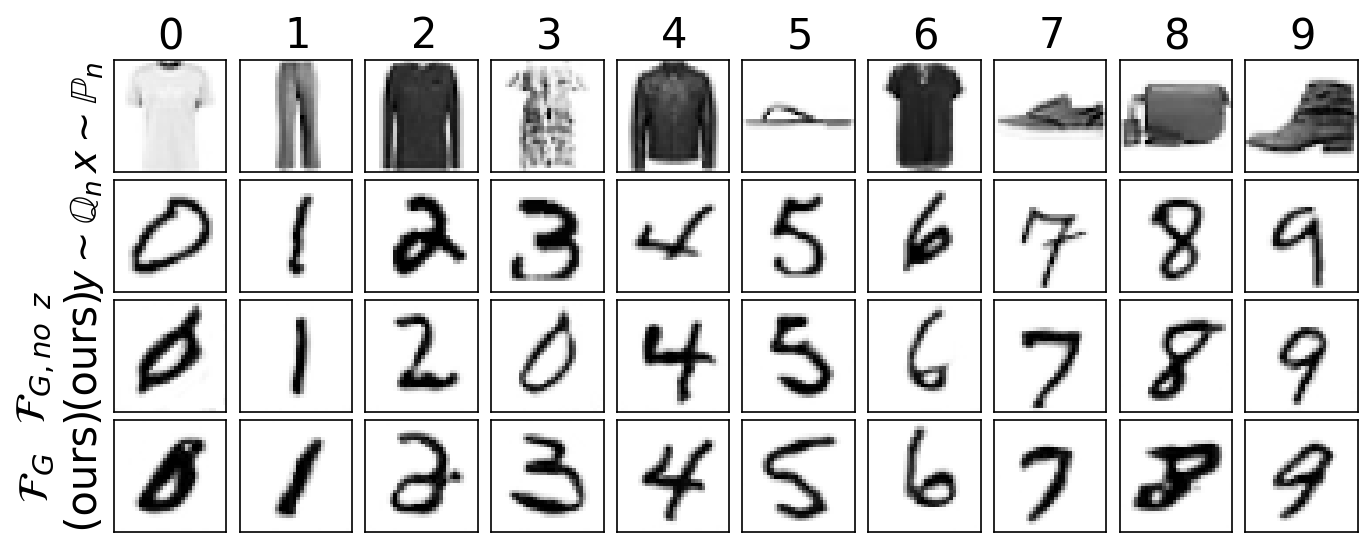

In [12]:
FID, accuracies, fig = plot_transport_results(X_fixed.flatten(start_dim=0, end_dim=1), 
                                              Y_fixed.flatten(start_dim=0, end_dim=1), 
                                              models_path, 
                                              DATASET, 
                                              NC=NC,
                                              Z_STD=Z_STD,
                                              m_data=m_data,
                                              s_data=s_data,
                                              X_sampler = X_sampler, 
                                              labeled_X_sampler = labeled_X_sampler, 
                                              classifier = classifier,
                                              metrics=True)